In [1]:
# %% [markdown]
# # TCDM Embedding Visualization
#
# This notebook visualizes the time-coupled diffusion map (TCDM) embeddings
# from the selected embeddings pipeline.
#
# The embeddings are visualized as 3D scatter point clouds at different time points,
# showing how the latent manifold evolves over time.
#
# Data source: tc_selected_embeddings.pkl

In [2]:
from __future__ import annotations

import sys
from pathlib import Path
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm

# Add parent directory to path
path_root = Path.cwd().parent
if str(path_root) not in sys.path:
    sys.path.insert(0, str(path_root))

from scripts.pca.pca_visualization_utils import _format_for_paper

print("Imports successful!")

# %% [markdown]
# ## Paper Formatting

Imports successful!


In [3]:
_format_for_paper()
print("✓ Applied paper formatting")

# %% [markdown]
# ## Load TCDM Embeddings

✓ Applied paper formatting


In [4]:
# Load the pkl file
data_path = Path(path_root) / "data/cache_pca_precomputed_unscaled_9999/tran_inclusions_unscaled_9999/tc_selected_embeddings.pkl"
print(f"Loading data from: {data_path}")

with open(data_path, 'rb') as f:
    data = pickle.load(f)

# Extract embeddings and metadata
selected_result = data['data']['selected_result']
embeddings_time = selected_result['embeddings_time']  # (T, N, D)
times = selected_result['times']  # (T,)
marginal_times = data['data']['marginal_times']  # (T,)

# Shape information
T, N, D = embeddings_time.shape
print(f"\nData loaded successfully!")
print(f"  Time points: {T}")
print(f"  Samples per time: {N}")
print(f"  Embedding dimension: {D}")
print(f"  Time values: {times}")
print(f"  Marginal times: {marginal_times}")

# Also load train/test splits if we want to visualize them separately
train_idx = data['data']['train_idx']
test_idx = data['data']['test_idx']
print(f"  Train samples: {len(train_idx)}")
print(f"  Test samples: {len(test_idx)}")

# %% [markdown]
# ## 3D Visualization Across Time
#
# Visualize the first 3 dimensions of the embeddings as a 3D point cloud
# for each time point. We'll subsample for clearer visualization.

Loading data from: /data1/jy384/research/MMSFM/data/cache_pca_precomputed_unscaled_9999/tran_inclusions_unscaled_9999/tc_selected_embeddings.pkl

Data loaded successfully!
  Time points: 5
  Samples per time: 5000
  Embedding dimension: 1280
  Time values: [0.14285714 0.42857143 0.57142857 0.85714286 1.        ]
  Marginal times: [0.14285714 0.42857143 0.57142857 0.85714286 1.        ]
  Train samples: 4000
  Test samples: 1000


In [5]:
def plot_embeddings_3d(
    embeddings_time,
    times,
    n_samples=1000,
    dims=(0, 1, 2),
    figsize_per_subplot=(4.5, 4),
    alpha=0.3,
    s=5,
    use_colormap=True,
    save_path=None,
):
    """Plot 3D scatter of embeddings at each time point.

    Args:
        embeddings_time: Array of shape (T, N, D) with embeddings
        times: Array of shape (T,) with time values
        n_samples: Number of samples to plot per time point
        dims: Tuple of 3 dimension indices to plot
        figsize_per_subplot: Size of each subplot
        alpha: Point transparency
        s: Point size
        use_colormap: If True, color points by time. If False, use single color per subplot.
        save_path: Optional path to save figure
    """
    T, N, D = embeddings_time.shape

    # Subsample if needed
    if n_samples < N:
        rng = np.random.default_rng(42)
        sample_idx = rng.choice(N, size=n_samples, replace=False)
    else:
        sample_idx = np.arange(N)
        n_samples = N

    # Setup subplot grid
    n_cols = min(T, 3)
    n_rows = (T + n_cols - 1) // n_cols

    fig = plt.figure(figsize=(figsize_per_subplot[0] * n_cols, figsize_per_subplot[1] * n_rows))
    gs = GridSpec(n_rows, n_cols, figure=fig, hspace=0.3, wspace=0.3)

    # Compute global axis limits for consistent scaling
    all_points = embeddings_time[:, sample_idx, :][:, :, dims].reshape(-1, 3)
    global_min = all_points.min(axis=0)
    global_max = all_points.max(axis=0)
    margin = (global_max - global_min) * 0.1

    # Color setup
    if use_colormap:
        cmap = cm.get_cmap('viridis')
        norm = plt.Normalize(vmin=times.min(), vmax=times.max())

    # Plot each time point
    for t_idx in range(T):
        row, col = t_idx // n_cols, t_idx % n_cols
        ax = fig.add_subplot(gs[row, col], projection='3d')

        # Extract data for this time point
        emb = embeddings_time[t_idx, sample_idx, :][:, dims]
        t_val = times[t_idx]

        # Color
        if use_colormap:
            color = cmap(norm(t_val))
        else:
            color = cmap(t_idx / max(T - 1, 1))

        # Scatter plot
        ax.scatter(emb[:, 0], emb[:, 1], emb[:, 2],
                  c=[color], alpha=alpha, s=s, edgecolors='none')

        # Axis limits and labels
        ax.set_xlim(global_min[0] - margin[0], global_max[0] + margin[0])
        ax.set_ylim(global_min[1] - margin[1], global_max[1] + margin[1])
        ax.set_zlim(global_min[2] - margin[2], global_max[2] + margin[2])

        ax.set_xlabel(f'$\\phi_{{{dims[0]}}}$', fontsize=9)
        ax.set_ylabel(f'$\\phi_{{{dims[1]}}}$', fontsize=9)
        ax.set_zlabel(f'$\\phi_{{{dims[2]}}}$', fontsize=9)

        ax.set_title(f't = {t_val:.3f}', fontsize=11)

        # Adjust viewing angle for better visibility
        ax.view_init(elev=20, azim=45)

        # Reduce tick label size
        ax.tick_params(labelsize=7)

    # Add colorbar if using colormap
    if use_colormap:
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=fig.get_axes(), orientation='horizontal',
                           fraction=0.05, pad=0.08, aspect=30)
        cbar.set_label('Time', fontsize=10)

    fig.suptitle('TCDM Embeddings: 3D Latent Manifold Evolution', fontsize=14, y=0.98)

    if save_path is not None:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved figure to: {save_path}")

    return fig

/tmp/ipykernel_2500617/343566002.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


Saved figure to: /data1/jy384/research/MMSFM/figures/tcdm_embeddings_3d_evolution.png


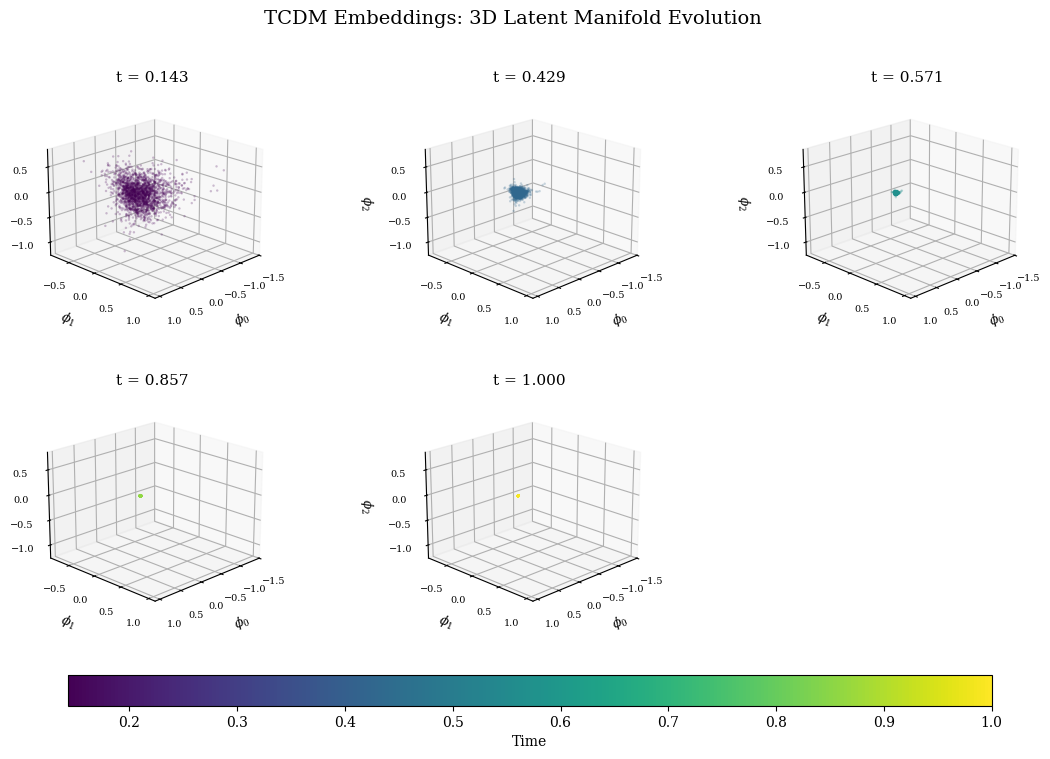

In [6]:
# Create visualization with all samples
fig = plot_embeddings_3d(
    embeddings_time,
    times,
    n_samples=2000,
    dims=(0, 1, 2),
    alpha=0.25,
    s=3,
    use_colormap=True,
    save_path=path_root / "figures/tcdm_embeddings_3d_evolution.png"
)
plt.show()

# %% [markdown]
# ## Alternative Views: Different Dimension Triplets


Plotting dimensions (0, 1, 2)


/tmp/ipykernel_2500617/343566002.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


Saved figure to: /data1/jy384/research/MMSFM/figures/tcdm_embeddings_3d_dims_0_1_2.png


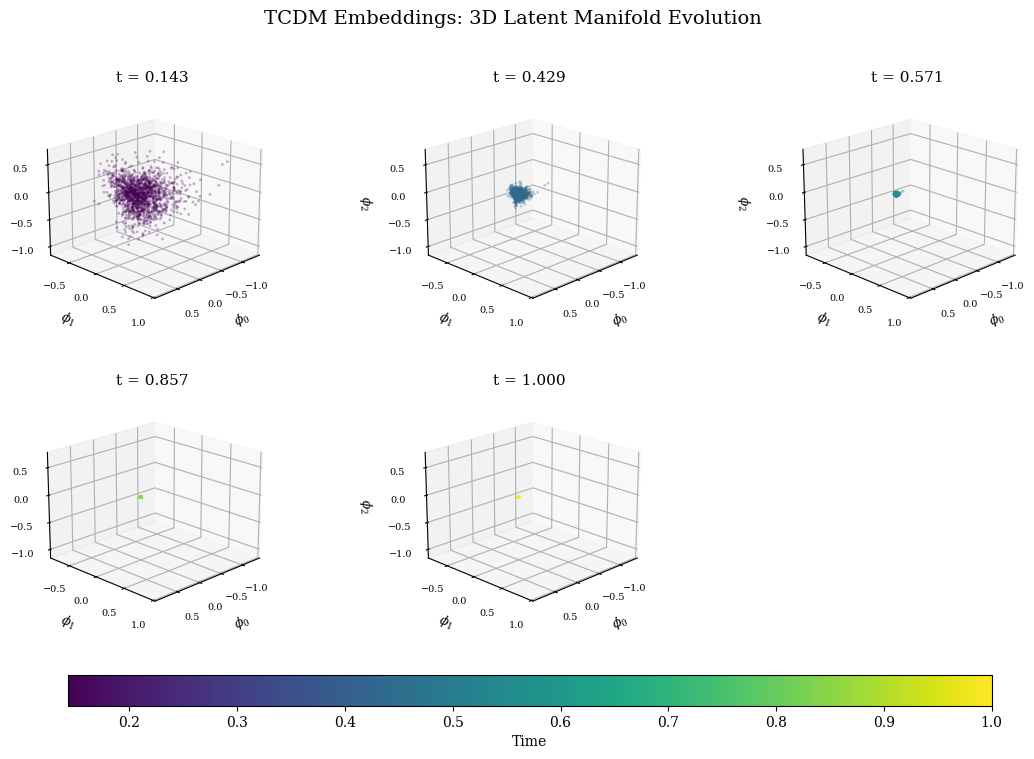


Plotting dimensions (3, 4, 5)
Saved figure to: /data1/jy384/research/MMSFM/figures/tcdm_embeddings_3d_dims_3_4_5.png


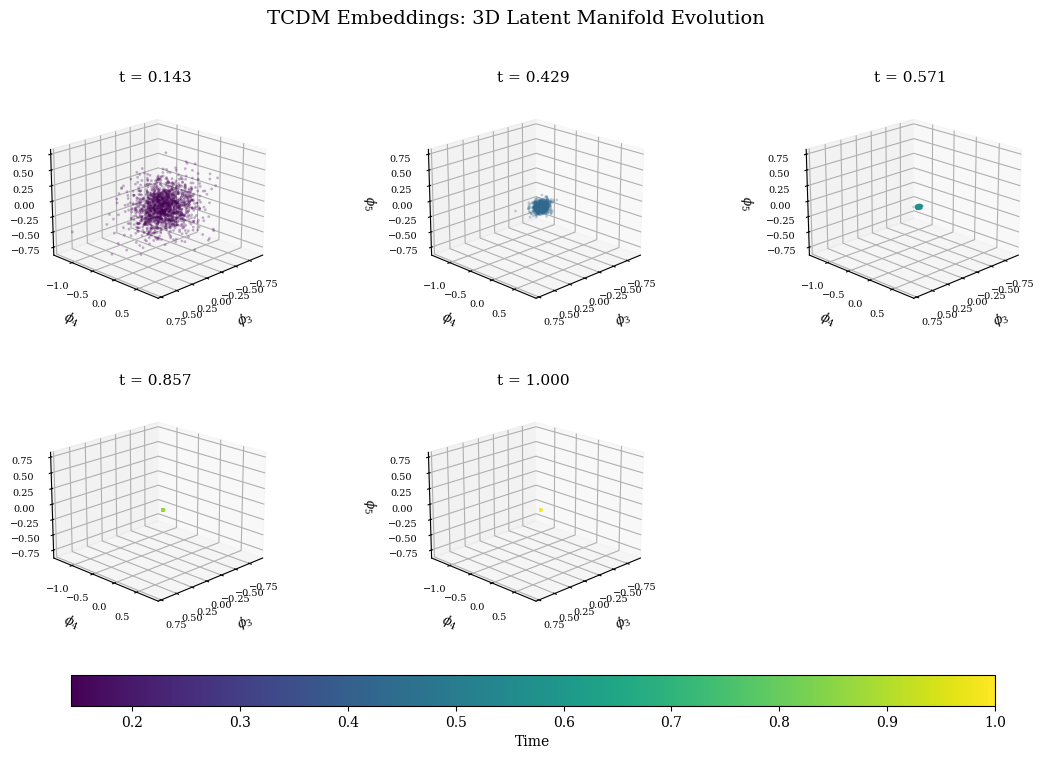


Plotting dimensions (6, 7, 8)
Saved figure to: /data1/jy384/research/MMSFM/figures/tcdm_embeddings_3d_dims_6_7_8.png


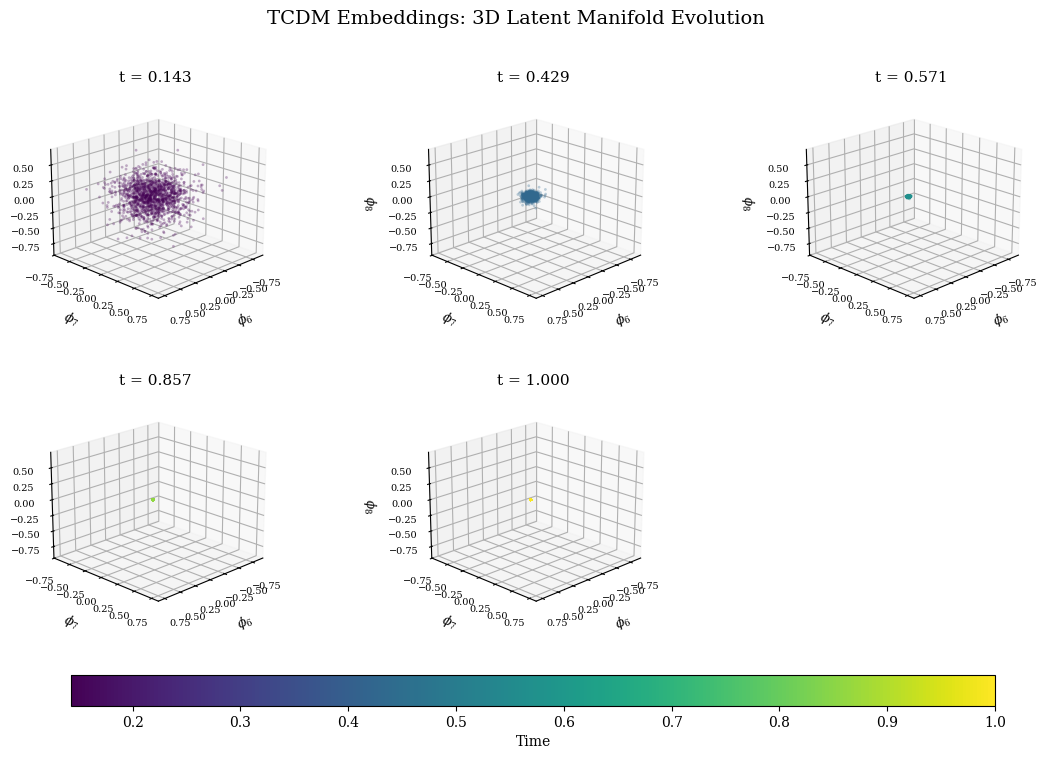


Plotting dimensions (0, 2, 4)
Saved figure to: /data1/jy384/research/MMSFM/figures/tcdm_embeddings_3d_dims_0_2_4.png


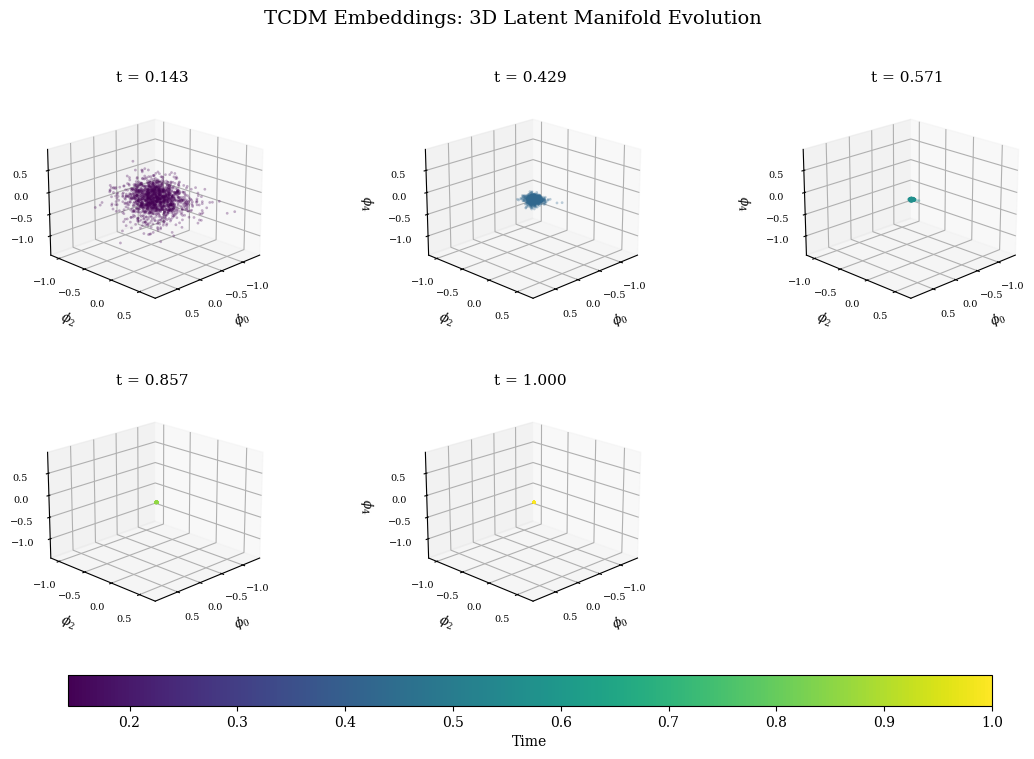

In [7]:
# Plot different dimension combinations to explore the manifold
dimension_triplets = [
    (0, 1, 2),
    (3, 4, 5),
    (6, 7, 8),
    (0, 2, 4),
]

for dims in dimension_triplets:
    if all(d < D for d in dims):
        print(f"\nPlotting dimensions {dims}")
        fig = plot_embeddings_3d(
            embeddings_time,
            times,
            n_samples=1500,
            dims=dims,
            alpha=0.3,
            s=4,
            use_colormap=True,
            save_path=path_root / f"figures/tcdm_embeddings_3d_dims_{'_'.join(map(str, dims))}.png"
        )
        plt.show()

# %% [markdown]
# ## Train vs Test Split Visualization
#
# Visualize train and test samples separately to check for any distributional differences.

In [8]:
def plot_train_test_comparison_3d(
    embeddings_time,
    times,
    train_idx,
    test_idx,
    n_samples_per_split=500,
    dims=(0, 1, 2),
    save_path=None,
):
    """Plot train and test embeddings side by side at each time point."""
    T, N, D = embeddings_time.shape

    # Subsample train and test
    rng = np.random.default_rng(42)
    if n_samples_per_split < len(train_idx):
        train_sample = rng.choice(train_idx, size=n_samples_per_split, replace=False)
    else:
        train_sample = train_idx

    if n_samples_per_split < len(test_idx):
        test_sample = rng.choice(test_idx, size=n_samples_per_split, replace=False)
    else:
        test_sample = test_idx

    # Setup subplot grid (2 rows per time point)
    n_cols = T
    n_rows = 2

    fig = plt.figure(figsize=(4 * n_cols, 4 * n_rows))
    gs = GridSpec(n_rows, n_cols, figure=fig, hspace=0.25, wspace=0.3)

    # Compute global axis limits
    all_points = embeddings_time[:, :, dims].reshape(-1, 3)
    global_min = all_points.min(axis=0)
    global_max = all_points.max(axis=0)
    margin = (global_max - global_min) * 0.1

    # Plot each time point
    for t_idx in range(T):
        t_val = times[t_idx]

        # Train subplot
        ax_train = fig.add_subplot(gs[0, t_idx], projection='3d')
        emb_train = embeddings_time[t_idx, train_sample, :][:, dims]
        ax_train.scatter(emb_train[:, 0], emb_train[:, 1], emb_train[:, 2],
                        c='blue', alpha=0.3, s=4, edgecolors='none', label='Train')
        ax_train.set_xlim(global_min[0] - margin[0], global_max[0] + margin[0])
        ax_train.set_ylim(global_min[1] - margin[1], global_max[1] + margin[1])
        ax_train.set_zlim(global_min[2] - margin[2], global_max[2] + margin[2])
        ax_train.set_title(f'Train (t={t_val:.3f})', fontsize=10)
        ax_train.set_xlabel(f'$\\phi_{{{dims[0]}}}$', fontsize=8)
        ax_train.set_ylabel(f'$\\phi_{{{dims[1]}}}$', fontsize=8)
        ax_train.set_zlabel(f'$\\phi_{{{dims[2]}}}$', fontsize=8)
        ax_train.view_init(elev=20, azim=45)
        ax_train.tick_params(labelsize=7)

        # Test subplot
        ax_test = fig.add_subplot(gs[1, t_idx], projection='3d')
        emb_test = embeddings_time[t_idx, test_sample, :][:, dims]
        ax_test.scatter(emb_test[:, 0], emb_test[:, 1], emb_test[:, 2],
                       c='red', alpha=0.3, s=4, edgecolors='none', label='Test')
        ax_test.set_xlim(global_min[0] - margin[0], global_max[0] + margin[0])
        ax_test.set_ylim(global_min[1] - margin[1], global_max[1] + margin[1])
        ax_test.set_zlim(global_min[2] - margin[2], global_max[2] + margin[2])
        ax_test.set_title(f'Test (t={t_val:.3f})', fontsize=10)
        ax_test.set_xlabel(f'$\\phi_{{{dims[0]}}}$', fontsize=8)
        ax_test.set_ylabel(f'$\\phi_{{{dims[1]}}}$', fontsize=8)
        ax_test.set_zlabel(f'$\\phi_{{{dims[2]}}}$', fontsize=8)
        ax_test.view_init(elev=20, azim=45)
        ax_test.tick_params(labelsize=7)

    fig.suptitle('TCDM Embeddings: Train vs Test Comparison', fontsize=14, y=0.98)

    if save_path is not None:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved figure to: {save_path}")

    return fig

Saved figure to: /data1/jy384/research/MMSFM/figures/tcdm_embeddings_train_test_comparison.png


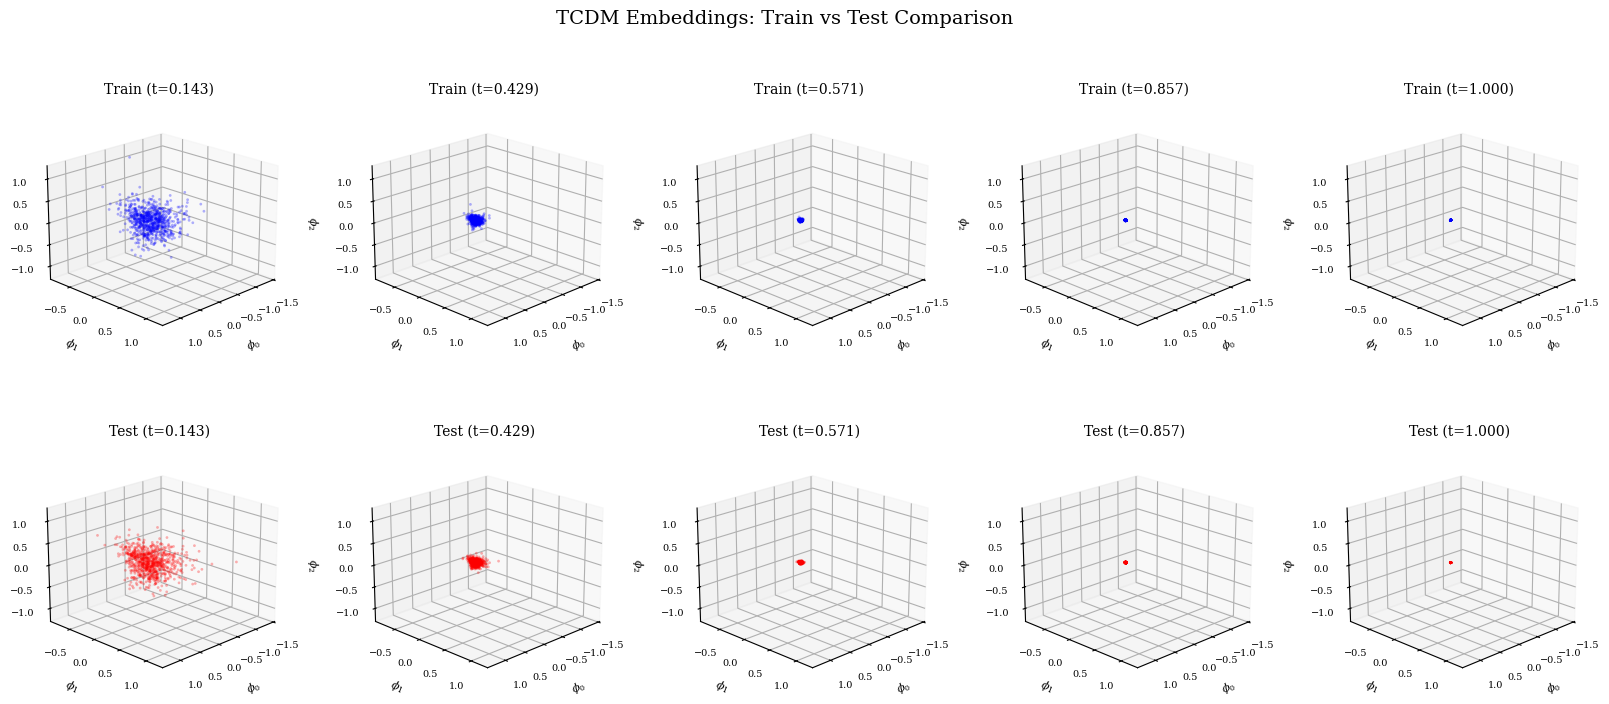

In [ ]:
fig = plot_train_test_comparison_3d(
    embeddings_time,
    times,
    train_idx,
    test_idx,
    n_samples_per_split=800,
    dims=(0, 1, 2),
    save_path=path_root / "figures/tcdm_embeddings_train_test_comparison.png"
)
plt.show()

# %% [markdown]
# ## Single Time Point - High Resolution
#
# Create a high-resolution visualization of a single time point for detailed inspection.

In [10]:
def plot_single_time_3d(
    embeddings,
    time_val,
    n_samples=3000,
    dims=(0, 1, 2),
    figsize=(10, 8),
    save_path=None,
):
    """Plot a single time point with high resolution."""
    N, D = embeddings.shape

    # Subsample if needed
    if n_samples < N:
        rng = np.random.default_rng(42)
        sample_idx = rng.choice(N, size=n_samples, replace=False)
    else:
        sample_idx = np.arange(N)

    emb = embeddings[sample_idx, :][:, dims]

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Color by distance from center for visual depth
    center = emb.mean(axis=0)
    distances = np.linalg.norm(emb - center, axis=1)

    scatter = ax.scatter(emb[:, 0], emb[:, 1], emb[:, 2],
                        c=distances, cmap='viridis', alpha=0.4, s=8, edgecolors='none')

    ax.set_xlabel(f'$\\phi_{{{dims[0]}}}$', fontsize=12)
    ax.set_ylabel(f'$\\phi_{{{dims[1]}}}$', fontsize=12)
    ax.set_zlabel(f'$\\phi_{{{dims[2]}}}$', fontsize=12)
    ax.set_title(f'TCDM Embedding at t = {time_val:.3f}', fontsize=14)

    # Add colorbar
    cbar = fig.colorbar(scatter, ax=ax, pad=0.1, shrink=0.8)
    cbar.set_label('Distance from Center', fontsize=10)

    ax.view_init(elev=20, azim=45)

    if save_path is not None:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=200, bbox_inches='tight')
        print(f"Saved figure to: {save_path}")

    return fig

Saved figure to: /data1/jy384/research/MMSFM/figures/tcdm_embedding_t1.000_highres.png


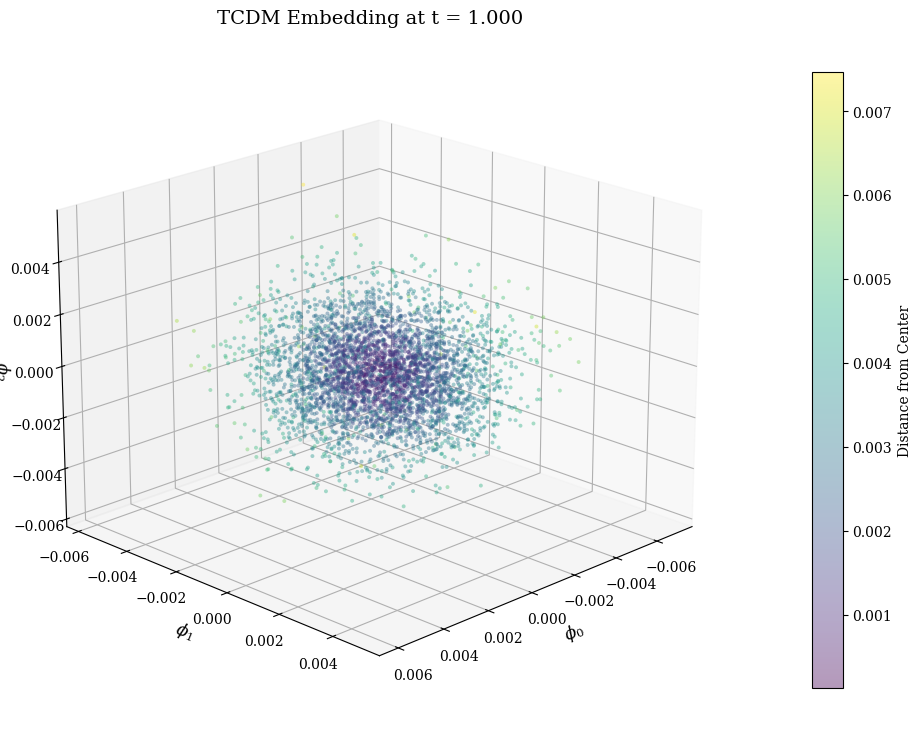

In [11]:
# Plot the final time point (t=1.0) in high resolution
final_time_idx = -1
fig = plot_single_time_3d(
    embeddings_time[final_time_idx],
    times[final_time_idx],
    n_samples=4000,
    dims=(0, 1, 2),
    figsize=(12, 10),
    save_path=path_root / f"figures/tcdm_embedding_t{times[final_time_idx]:.3f}_highres.png"
)
plt.show()

# %% [markdown]
# ## Summary Statistics

In [12]:
print("\n" + "="*70)
print("TCDM Embedding Statistics")
print("="*70)

for t_idx in range(T):
    emb = embeddings_time[t_idx]
    t_val = times[t_idx]

    mean_vals = emb.mean(axis=0)[:5]  # First 5 dims
    std_vals = emb.std(axis=0)[:5]

    print(f"\nTime t={t_val:.3f}:")
    print(f"  Mean (first 5 dims): {mean_vals}")
    print(f"  Std  (first 5 dims): {std_vals}")
    print(f"  Global mean: {emb.mean():.4f}")
    print(f"  Global std:  {emb.std():.4f}")

print("\n" + "="*70)


TCDM Embedding Statistics

Time t=0.143:
  Mean (first 5 dims): [ 0.00226253  0.00288999 -0.00236886  0.00040283  0.00262757]
  Std  (first 5 dims): [0.2291153  0.22804253 0.21945685 0.21582491 0.20882236]
  Global mean: 0.0000
  Global std:  0.0393

Time t=0.429:
  Mean (first 5 dims): [ 4.89274838e-04  7.11846096e-04 -4.86373782e-04  8.73865333e-05
  6.07569952e-04]
  Std  (first 5 dims): [0.05468868 0.0524094  0.04921445 0.04650264 0.04420888]
  Global mean: 0.0000
  Global std:  0.0049

Time t=0.571:
  Mean (first 5 dims): [ 1.09715473e-04  1.94048633e-04 -8.52424643e-05  4.82855859e-05
  1.19422703e-04]
  Std  (first 5 dims): [0.01375102 0.01274039 0.0117324  0.01082367 0.0097184 ]
  Global mean: 0.0000
  Global std:  0.0009

Time t=0.857:
  Mean (first 5 dims): [ 2.46512586e-05  6.75221705e-05 -7.76487369e-06  1.78207754e-05
  2.27230753e-05]
  Std  (first 5 dims): [0.00444391 0.00408055 0.00362608 0.00339295 0.00248837]
  Global mean: 0.0000
  Global std:  0.0003

Time t=1.000: